# Day High in 5m timeframe - Detection(Predict, Classification, Clustering)

### Import Library

In [97]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [98]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [99]:
data = dataset.copy()

In [100]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


In [101]:
def labeling_data(df):
    tmp_data = df.copy()
    tmp_data['DayHigh'] = tmp_data['High']
    daily_data = tmp_data.resample('D').agg({
            'DayHigh': 'max'
        })
    daily_data.dropna(subset=['DayHigh'], inplace=True)
    #
    data = df.copy()
    data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
    #
    merged_data = pd.merge(data, daily_data, left_on="time_d", right_index=True, how="left")
    merged_data['hour'] = merged_data.index.hour
    merged_data['minute'] = merged_data.index.minute
    merged_data['prev_High'] = merged_data['High'].shift(1)
    merged_data['prev_Low'] = merged_data['Low'].shift(1)
    merged_data['prev_Close'] = merged_data['Close'].shift(1)
    merged_data['prev_Open'] = merged_data['Open'].shift(1)
    merged_data['prev_Vol'] = merged_data['Volume'].shift(1)
    merged_data['is_max'] = merged_data.apply(lambda r: 1 if r["High"] == r["DayHigh"] else 0, axis=1)
    ana_data = merged_data.dropna()
    ana_data['upper_shadow'] = ana_data.apply(lambda r: r["High"] - max(r["Open"], r["Close"]), axis=1)
    ana_data['prev_upper_shadow'] = ana_data['upper_shadow'].shift(1)
    ana_data['ibs'] = ana_data.apply(
        lambda r: 0 if r["High"] == r["Low"] else (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
    ana_data['prev_ibs'] = ana_data['ibs'].shift(1)
    ana_data['RSI20'] = ta.rsi(ana_data["Close"], length=20)
    ana_data['RSI10'] = ta.rsi(ana_data["Close"], length=10)
    ana_data['avg_Volume'] = ana_data['Volume'].rolling(20).mean()
    ana_data['prev_avg_Volume'] = ana_data['avg_Volume'].shift(1)
    ana_data["MB"] = ana_data["Close"].rolling(20).mean()
    ana_data["STD"] = ana_data["Close"].rolling(20).std()
    ana_data["UB"] = ana_data["MB"] + 1.5 * ana_data["STD"]
    #
    ana_data['upper_wick_group'] = ana_data.apply(
        lambda r: 1 if r["upper_shadow"] > r["prev_upper_shadow"] else -1, axis=1)
    ana_data["ibs_vol_group"] = ana_data.apply(lambda r: get_ibs_vol_group(r), axis=1)
    ana_data['rsi_area'] = ana_data.apply(
        lambda r: 1 if r["RSI20"] > 55 else (0.33 if r["RSI20"] < 45 else 0.66), axis=1)
    ana_data['higher_high_lower_vol'] = ana_data.apply(
        lambda r: 1 if (r["High"] > r["prev_High"] and r["Volume"] < r["prev_Vol"]) else -1, axis=1)
    ana_data['Volume_higher_avg'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["avg_Volume"] else -1, axis=1)
    ana_data['Volume_vs_prev_Vol'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["prev_Vol"] else -1, axis=1)
    ana_data['Volume_avg_group'] = ana_data.apply(
        lambda r: 1 if r["avg_Volume"] > r["prev_avg_Volume"] else -1, axis=1)
    ana_data['close_price_group'] = ana_data.apply(lambda r: get_close_price_position(r), axis=1)
    ana_data['open_price_group'] = ana_data.apply(lambda r: get_open_price_position(r), axis=1)
    ana_data['High_position'] = ana_data.apply(lambda r: 1 if r["High"] > r["UB"] else -1, axis=1)
    ana_data["BB_rejection"] = ana_data.apply(lambda r: 1 if r["Close"] < r["UB"] else -1, axis=1)
    ana_data.dropna(inplace=True)
    return ana_data


def get_open_price_position(r):
    if r["Open"] > r["prev_Close"]:
        return -0.5
    if r["Open"] == r["prev_Close"]:
        return 0
    if r["Open"] < r["prev_Close"]:
        return 0.5


def get_ibs_vol_group(r):
    if r["Volume"] > r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return -1
    if r["Volume"] > r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return -0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return 0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return 1


def get_close_price_position(r):
    if r["Close"] > r["prev_High"]:
        return -1
    if r["Close"] > max(r["prev_Close"], r["prev_Open"]):
        return -0.5
    if max(r["prev_Close"], r["prev_Open"]) > r["Close"] > min(r["prev_Close"], r["prev_Open"]):
        return 0
    if r["Close"] < min(r["prev_Close"], r["prev_Open"]):
        return 0.5
    if r["Close"] < r["prev_Low"]:
        return 1


In [102]:
labeled_data = labeling_data(data)

In [103]:
labeled_data

,Open,High,Low,Close,Volume,time_d,DayHigh,hour,minute,prev_High,...,ibs_vol_group,rsi_area,higher_high_lower_vol,Volume_higher_avg,Volume_vs_prev_Vol,Volume_avg_group,close_price_group,open_price_group,High_position,BB_rejection
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-13 10:45:00,943.5,943.5,942.9,943.5,1793,2018-08-13,954.6,10,45,945.0,...,-1.0,0.33,-1,1,1,1,0.5,0.5,-1,1
2018-08-13 10:50:00,943.6,943.8,942.3,943.2,1541,2018-08-13,954.6,10,50,943.5,...,1.0,0.33,1,1,-1,1,0.5,-0.5,-1,1
2018-08-13 10:55:00,943.2,944.1,942.7,943.7,1236,2018-08-13,954.6,10,55,943.8,...,0.5,0.33,1,-1,-1,1,-0.5,0.0,-1,1
2018-08-13 11:00:00,943.7,944.2,943.3,944.2,1477,2018-08-13,954.6,11,0,944.1,...,-1.0,0.33,-1,1,1,-1,-1.0,0.0,-1,1
2018-08-13 11:05:00,944.2,945.3,944.1,945.0,1434,2018-08-13,954.6,11,5,944.2,...,1.0,0.66,1,1,-1,-1,-1.0,0.0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379,2025-11-04,1907.7,14,10,1891.0,...,1.0,1.00,-1,-1,-1,1,0.5,-0.5,1,1
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871,2025-11-04,1907.7,14,15,1891.0,...,-1.0,1.00,-1,1,1,1,-1.0,0.5,1,-1
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090,2025-11-04,1907.7,14,20,1899.0,...,-0.5,1.00,-1,1,1,1,-1.0,0.5,1,-1


## AI prediction

In [104]:
train_data = labeled_data[(labeled_data.index > '2020-01-01 00:00:00') & (labeled_data.index < '2025-01-01 00:00:00')]
test_data = labeled_data[labeled_data.index > '2025-01-01 00:00:00']

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from xgboost import plot_importance

In [106]:
features = [
    "upper_wick_group", "ibs_vol_group", "rsi_area", "higher_high_lower_vol",
    "Volume_higher_avg", "Volume_vs_prev_Vol", "Volume_avg_group",
    "close_price_group", "open_price_group", "High_position", "BB_rejection"
]

In [107]:
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data["is_max"]
y_test = test_data["is_max"]

In [108]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
ratio = neg / pos
print("scale_pos_weight =", ratio)

scale_pos_weight = 46.97967823878069


In [109]:
model_xgb = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,   # xử lý imbalance
    eval_metric="logloss",
    tree_method="hist"        # nhanh nhất
)

model_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

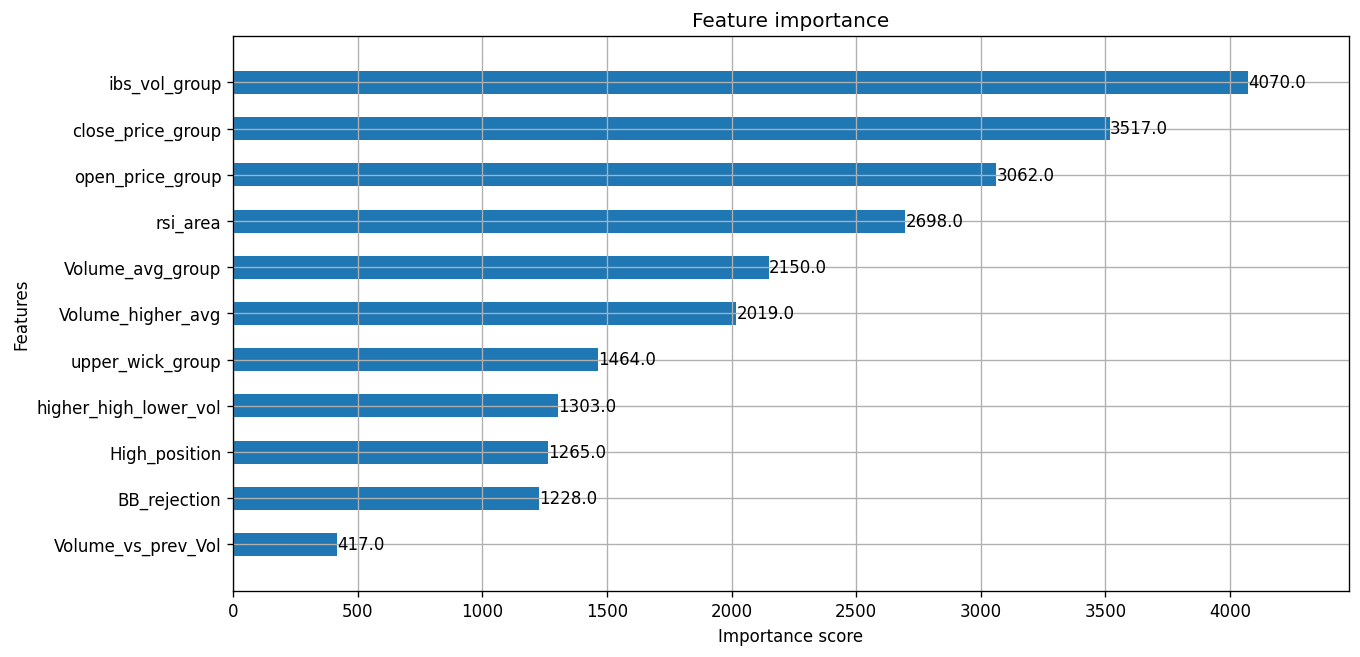

In [110]:
plot_importance(model_xgb, max_num_features=20, height=0.5)

In [111]:
proba = model_xgb.predict_proba(X_test)[:, 1]

In [112]:
print("AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))

AUC: 0.8906499296771657
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      9353
           1       0.06      0.91      0.11       207

    accuracy                           0.69      9560
   macro avg       0.53      0.80      0.46      9560
weighted avg       0.98      0.69      0.80      9560



### Tối ưu threshold để có nhiều tín hiệu hơn

In [113]:
best_t = 0
best_f1 = 0

for t in np.linspace(0.01, 0.3, 60):
    pred = (proba > t).astype(int)
    f1 = f1_score(y_test, pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)

Best threshold: 0.2852542372881356
Best F1: 0.11246652781910146


In [114]:
precision, recall, thresholds = precision_recall_curve(y_test, proba)

beta = 2.0
f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

best_threshold = thresholds[np.argmax(f_beta)]

print("Best threshold:", best_threshold)

Best threshold: 0.96300095


In [138]:
best_tx = 0
best_score = 0

for t in np.linspace(0.01, 1, 200):
    pred = (proba > t).astype(int)
    tp = np.sum((y_test == 1) & (pred == 1))
    tpx = np.sum((y_test == 0) & (pred == 1))
    score = tp * 5 -tpx
    if score > best_score:
        best_score = score
        best_t = t

print("Best threshold:", best_t)
print("Best score:", best_score)

Best threshold: 0.8756281407035176
Best score: 75


In [139]:
threshold = 0.876
pred = (proba > threshold).astype(int)

In [140]:
result = test_data.copy()
result['predict'] = pred

In [141]:
result[['Open', 'High', 'Low', 'Close', 'Volume', 'is_max', 'predict']]

,Open,High,Low,Close,Volume,is_max,predict
Date,,,,,,,
2025-01-02 09:35:00,1348.0,1349.4,1347.9,1349.4,11380,0,0
2025-01-02 09:40:00,1349.3,1351.2,1349.3,1350.8,7218,1,0
2025-01-02 09:45:00,1351.0,1351.0,1350.1,1350.4,3300,0,0
2025-01-02 09:50:00,1350.4,1350.4,1349.3,1349.9,2507,0,0
2025-01-02 09:55:00,1350.0,1350.0,1348.7,1348.7,1868,0,0
...,...,...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379,0,0
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871,0,0
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090,1,0


### Lost Money

In [142]:
result[(result.predict == 1) & (result.is_max == 0)][['is_max', 'predict']]

,is_max,predict
Date,,
2025-01-07 11:15:00,0,1
2025-01-07 11:20:00,0,1
2025-01-07 11:30:00,0,1
2025-01-08 13:20:00,0,1
2025-01-09 09:00:00,0,1
...,...,...
2025-10-24 14:00:00,0,1
2025-10-28 14:20:00,0,1
2025-10-29 13:25:00,0,1


### Missed Day-High

In [143]:
result[(result.predict != result.is_max) & (result.is_max == 1)][['is_max', 'predict']]

,is_max,predict
Date,,
2025-01-02 09:40:00,1,0
2025-01-06 10:30:00,1,0
2025-01-09 09:50:00,1,0
2025-01-10 09:25:00,1,0
2025-01-14 09:00:00,1,0
...,...,...
2025-10-28 14:25:00,1,0
2025-10-29 14:05:00,1,0
2025-10-30 09:00:00,1,0


### Wrong predict

In [144]:
result[result.predict != result.is_max][['is_max', 'predict']]

,is_max,predict
Date,,
2025-01-02 09:40:00,1,0
2025-01-06 10:30:00,1,0
2025-01-07 11:15:00,0,1
2025-01-07 11:20:00,0,1
2025-01-07 11:30:00,0,1
...,...,...
2025-10-29 14:05:00,1,0
2025-10-30 09:00:00,1,0
2025-10-31 09:00:00,1,0


### Correct predict

In [145]:
result[result.predict == result.is_max][['is_max', 'predict']]

,is_max,predict
Date,,
2025-01-02 09:35:00,0,0
2025-01-02 09:45:00,0,0
2025-01-02 09:50:00,0,0
2025-01-02 09:55:00,0,0
2025-01-02 10:00:00,0,0
...,...,...
2025-11-04 14:05:00,0,0
2025-11-04 14:10:00,0,0
2025-11-04 14:15:00,0,0


### Correct day High predict

In [146]:
result[(result.predict == result.is_max) & (result.is_max == 1)][['is_max', 'predict']]

,is_max,predict
Date,,
2025-01-07 13:00:00,1,1
2025-01-08 14:00:00,1,1
2025-01-16 09:30:00,1,1
2025-01-20 10:50:00,1,1
2025-01-23 14:20:00,1,1
...,...,...
2025-10-13 14:20:00,1,1
2025-10-21 14:10:00,1,1
2025-10-22 14:45:00,1,1
